# experiments on figure segmentation

In [193]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import torch
from torch.nn import functional
import copy
import matplotlib.pyplot as plt
import os
import json
from core.GMC import GMC
import h5py
import cv2
from utils.utils import eval, plot_result, eval2
from sklearn.model_selection import train_test_split

Our goal is

 $\lvert\mathbb{E}[ g(x)(1- \frac{\sum_iy_i\mathbb{1}_{\{h_i(x)> \lambda(x)\}}}{\sum_iy_i}-\sigma) ]\rvert\leq \alpha\quad \forall g\in \mathcal{G}$
 
 We set $\sigma=0.075, \alpha=0.005$

In [194]:
sigma = 0.075
alpha = 0.005

load data and split it into train sets, calibration sets and test sets.

In [195]:
data_path = os.path.join(os.getcwd(), '..','datasets/FigSeg/Result/result.h')
f = h5py.File(data_path, "r")
h,x,y = f['h'], np.array(list(f['x'])), f['y']
print('raw data shape: ', h.shape, x.shape, y.shape)
sample_size = h.shape[0]
# only consider the segmentation of face part
h += np.random.uniform(-0.1, 0.1, h.shape)
predict_label = (np.argmax(h, axis=1)==1).astype('int64').reshape(sample_size,-1)
h = h[:,1,:,:].reshape(sample_size,-1)
y = y[:,1,:,:].reshape(sample_size,-1)
print('h shape: ', h.shape, ' y shape: ', y.shape, 'predict_label shape: ', predict_label.shape)

raw data shape:  (118, 6, 256, 256) (118, 3, 256, 256) (118, 6, 256, 256)
h shape:  (118, 65536)  y shape:  (118, 65536) predict_label shape:  (118, 65536)


set sensitive subgroups

In [196]:
def GMC(alpha, eta, x_cal, y_cal, h_cal, x_test, h_test, s, group_G, f=(lambda x:0), f_test = (lambda x:0), T=500, proj=None):
    '''
    eta:learning_rate
    x_cal:numpy
    y_cal:numpy
    h_cal:numpy
    x_test:numpy
    h_test:numpy
    s:mapping_function
    f:initial_function 
    group_G:list of group functions
    T:max_iteration
    return function f
    ''' 
    fx = f(x_cal)
    fx_test = f_test(x_test)
    n = x_cal.shape[0]
    for i in range(T):
        update = False
        for g in group_G:
            #if g(x)@s((fx, x, y, h))>alpha*n:
            if g(x_cal)@s(fx, x_cal, y_cal, h_cal)>alpha*n:
                update = True
                break
        if update==False:
            print(i)
            print('end')
            break
        else:
            fx = fx - eta*g(x_cal)
            fx_test = fx_test - eta*g(x_test)
            if not (proj is None):
                fx = proj(fx)
                fx_test = proj(fx_test)
    return fx, fx_test

In [242]:
def generate_X():
    female = [3,4,5,7,8,10,12,14,18,19,20,21,22,23,25,27,31,32,36,38,39,40,41,42,43,44,46,47,48,50,51,52,53,54,55,59,60,73,74,75,76,77,78]
    white = [1,2,4,5,6,7,8,10,11,12,13,20,21,22,24,26,28,29,30,31,32,33,34,35,37,38,39,41,43,44,45,47,49,50,51,52,53,54,55,56,57]+[i for i in range(58, 119)]
    X = [2*int(x in female) + int(x in white) for x in range(1, sample_size + 1)]
    return X

def generate_G():
    female_g = lambda x:(x>=2).astype("int64")
    male_g = lambda x:(x<2).astype("int64")
    white_g = lambda x:((x==1).astype("int64")+(x==3).astype("int64"))
    non_white_g = lambda x: ((x==0).astype("int64")+(x==2).astype("int64"))
    return [female_g, male_g, white_g, non_white_g, lambda x:-female_g(x), lambda x:-male_g(x), lambda x:-white_g(x), lambda x:-non_white_g(x)]
X = np.array(generate_X())
print('X shape:', X.shape)
x_cal, x_test, h_cal, h_test, y_cal, y_test, predict_label_cal, predict_label_test = train_test_split(X, h, y, predict_label, test_size=0.3, random_state=42)#42
G = generate_G()
def s(lamda, x, y,h):
    shape2 = h.shape[1]
    lamda = lamda[:,None].repeat(shape2,axis=1)
    intersect = ((h>lamda)*y).sum(axis=1)
    return 1-intersect/(y.sum(axis=1))-sigma
eta = 0.01
fx, fx_test = GMC(alpha/3, eta,x_cal, y_cal, h_cal, x_test, h_test, s, G, f=(lambda x:np.array([1.5])),f_test=(lambda x:np.array([1.5])),T=100)

X shape: (118,)
75
end


baseline 0: origin output

In [243]:
fx_b0, fx_test_b0 = np.ones(x_cal.shape[0])*0.5, np.ones(x_test.shape[0])*0.5

baseline 1: conformal

In [244]:
def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1) ) >= alpha) - 1, 0) # Can't be -1.
    return lambdas[lhat_idx]
lambda_table = np.linspace(0,2,100)
calib_losses = np.array([s(np.ones(x_cal.shape[0])*lhat, x_cal, y_cal, h_cal) for lhat in lambda_table]).transpose(1,0)
lhat = get_lhat(calib_losses, lambda_table, alpha)
fx_b, fx_test_b = np.ones(x_cal.shape[0])*lhat, np.ones(y_test.shape[0])*lhat

plot the mapping function over different subgroups

In [245]:
selected_G = G[:4]
G2 = [lambda x:(x>=0).astype("int64")]+[lambda x:-(x>=0).astype("int64")]
category = ['female','male','white','non-white']
cal_result = eval(selected_G, s, fx, x_cal, y_cal, h_cal)
cal_result_b0 = eval(selected_G, s, fx_b0, x_cal, y_cal, predict_label_cal)
cal_result_b = eval(selected_G, s, fx_b, x_cal, y_cal, h_cal)
test_result = eval(selected_G, s, fx_test, x_test, y_test, h_test)
test_result_b0 = eval(selected_G, s, fx_test_b0, x_test, y_test, predict_label_test)
test_result_b = eval(selected_G, s, fx_test_b, x_test, y_test, h_test)

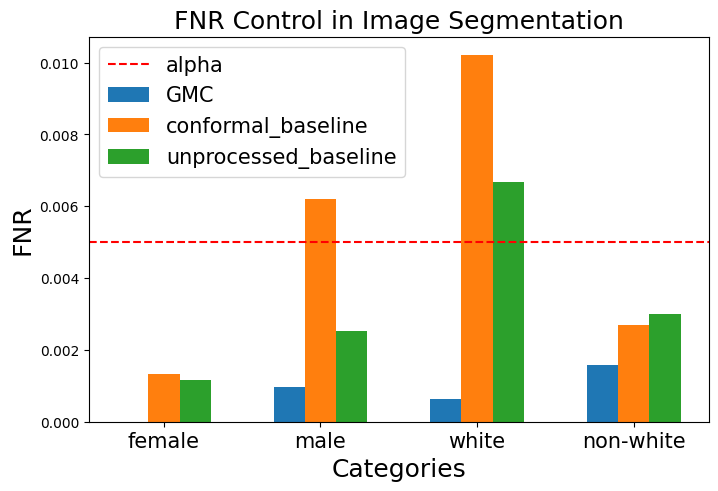

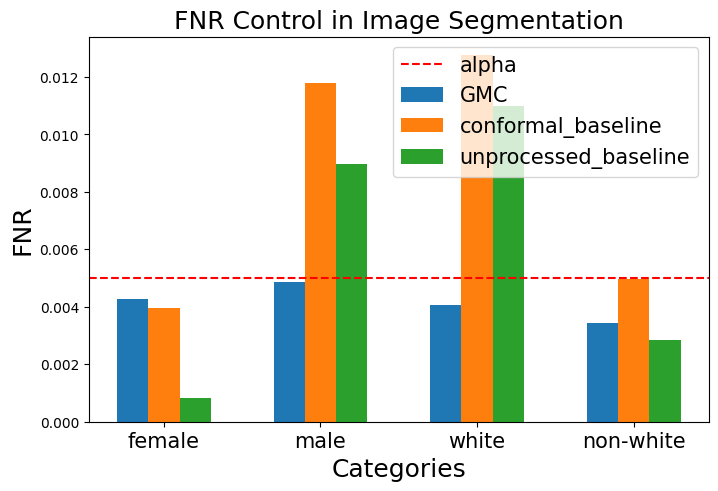

In [246]:
# plot_result(category, cal_result+sigma, cal_result_b+sigma, cal_result_b0+sigma, 'Categories', 'FNR', 'FNR Control in Image Segmentation', sigma)
# plot_result(category, test_result+sigma, test_result_b+sigma, test_result_b0+sigma, 'Categories', 'FNR', 'FNR Control in Image Segmentation', sigma)
plot_result(category, np.abs(cal_result), np.abs(cal_result_b), np.abs(cal_result_b0), 'Categories', 'FNR', 'FNR Control in Image Segmentation', alpha)
plot_result(category, np.abs(test_result), np.abs(test_result_b), np.abs(test_result_b0), 'Categories', 'FNR', 'FNR Control in Image Segmentation', alpha)

In [203]:
def accuracy(lamda, x, y,h):
    shape2 = h.shape[1]
    lamda = lamda[:,None].repeat(shape2,axis=1)
    accurate = ((h>lamda)==y).sum(axis=1)
    return accurate/shape2
G2 = [lambda x:(x>=0).astype("int64")]+[lambda x:-(x>=0).astype("int64")]
selected_G2 = selected_G + G2[:1]
cal_accu = eval2(selected_G2, accuracy, fx, x_cal, y_cal, h_cal)
cal_accu_b = eval2(selected_G2, accuracy, fx_b, x_cal, y_cal, h_cal)
cal_accu_b0 = eval2(selected_G2, accuracy, fx_b0, x_cal, y_cal, predict_label_cal)
test_accu = eval2(selected_G2, accuracy, fx_test, x_test, y_test, h_test)
test_accu_b = eval2(selected_G2, accuracy, fx_test_b, x_test, y_test, h_test)
test_accu_b0 = eval2(selected_G2, accuracy, fx_test_b0, x_test, y_test, predict_label_test)

In [204]:
print(test_accu[-1], test_accu_b[-1], test_accu_b0[-1])

0.8567682902018229 0.8344311184353299 0.9188482496473525
